## Import Modules

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline

import tensorflow as tf
from keras.preprocessing.image import load_img
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input

## Load the Dataset

In [3]:
BASE_DIR = '../input/utkface-new/UTKFace/'

In [4]:
# labels - age, gender, ethnicity
image_paths = []
age_labels = []
gender_labels = []

for filename in tqdm(os.listdir(BASE_DIR)):
    image_path = os.path.join(BASE_DIR, filename)
    temp = filename.split('_')
    age = int(temp[0])
    gender = int(temp[1])
    image_paths.append(image_path)
    age_labels.append(age)
    gender_labels.append(gender)

  0%|          | 0/23708 [00:00<?, ?it/s]

In [5]:
# convert to dataframe
df = pd.DataFrame()
df['image'], df['age'], df['gender'] = image_paths, age_labels, gender_labels
df.head()

,image,age,gender
0,../input/utkface-new/UTKFace/26_0_2_2017010402...,26,0
1,../input/utkface-new/UTKFace/22_1_1_2017011223...,22,1
2,../input/utkface-new/UTKFace/21_1_3_2017010500...,21,1
3,../input/utkface-new/UTKFace/28_0_0_2017011718...,28,0
4,../input/utkface-new/UTKFace/17_1_4_2017010322...,17,1


In [6]:
# map labels for gender
gender_dict = {0:'Male', 1:'Female'}

## Exploratory Data Analysis

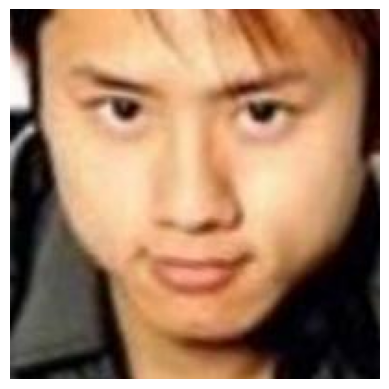

In [7]:
from PIL import Image
img = Image.open(df['image'][0])
plt.axis('off')
plt.imshow(img);

<Axes: xlabel='age', ylabel='Density'>

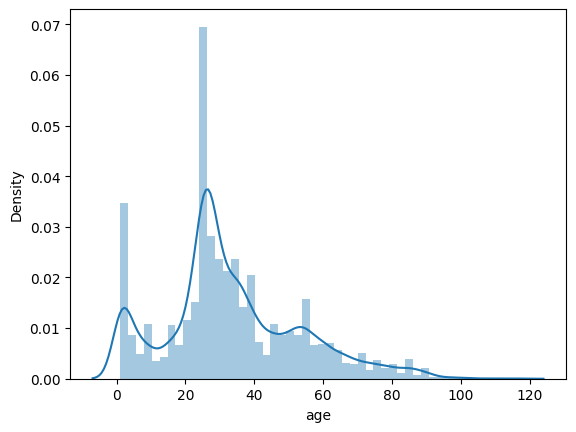

In [8]:
sns.distplot(df['age'])

<Axes: ylabel='count'>

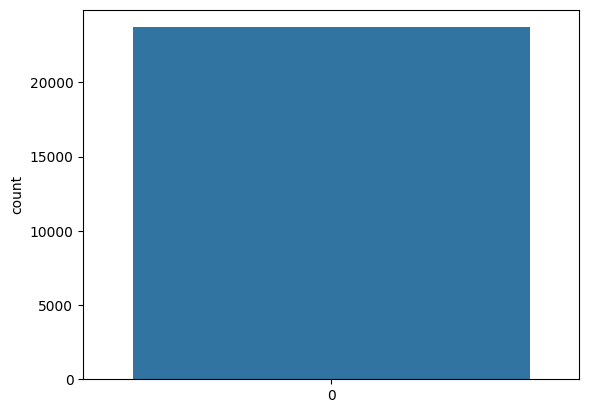

In [9]:
sns.countplot(df['gender'])

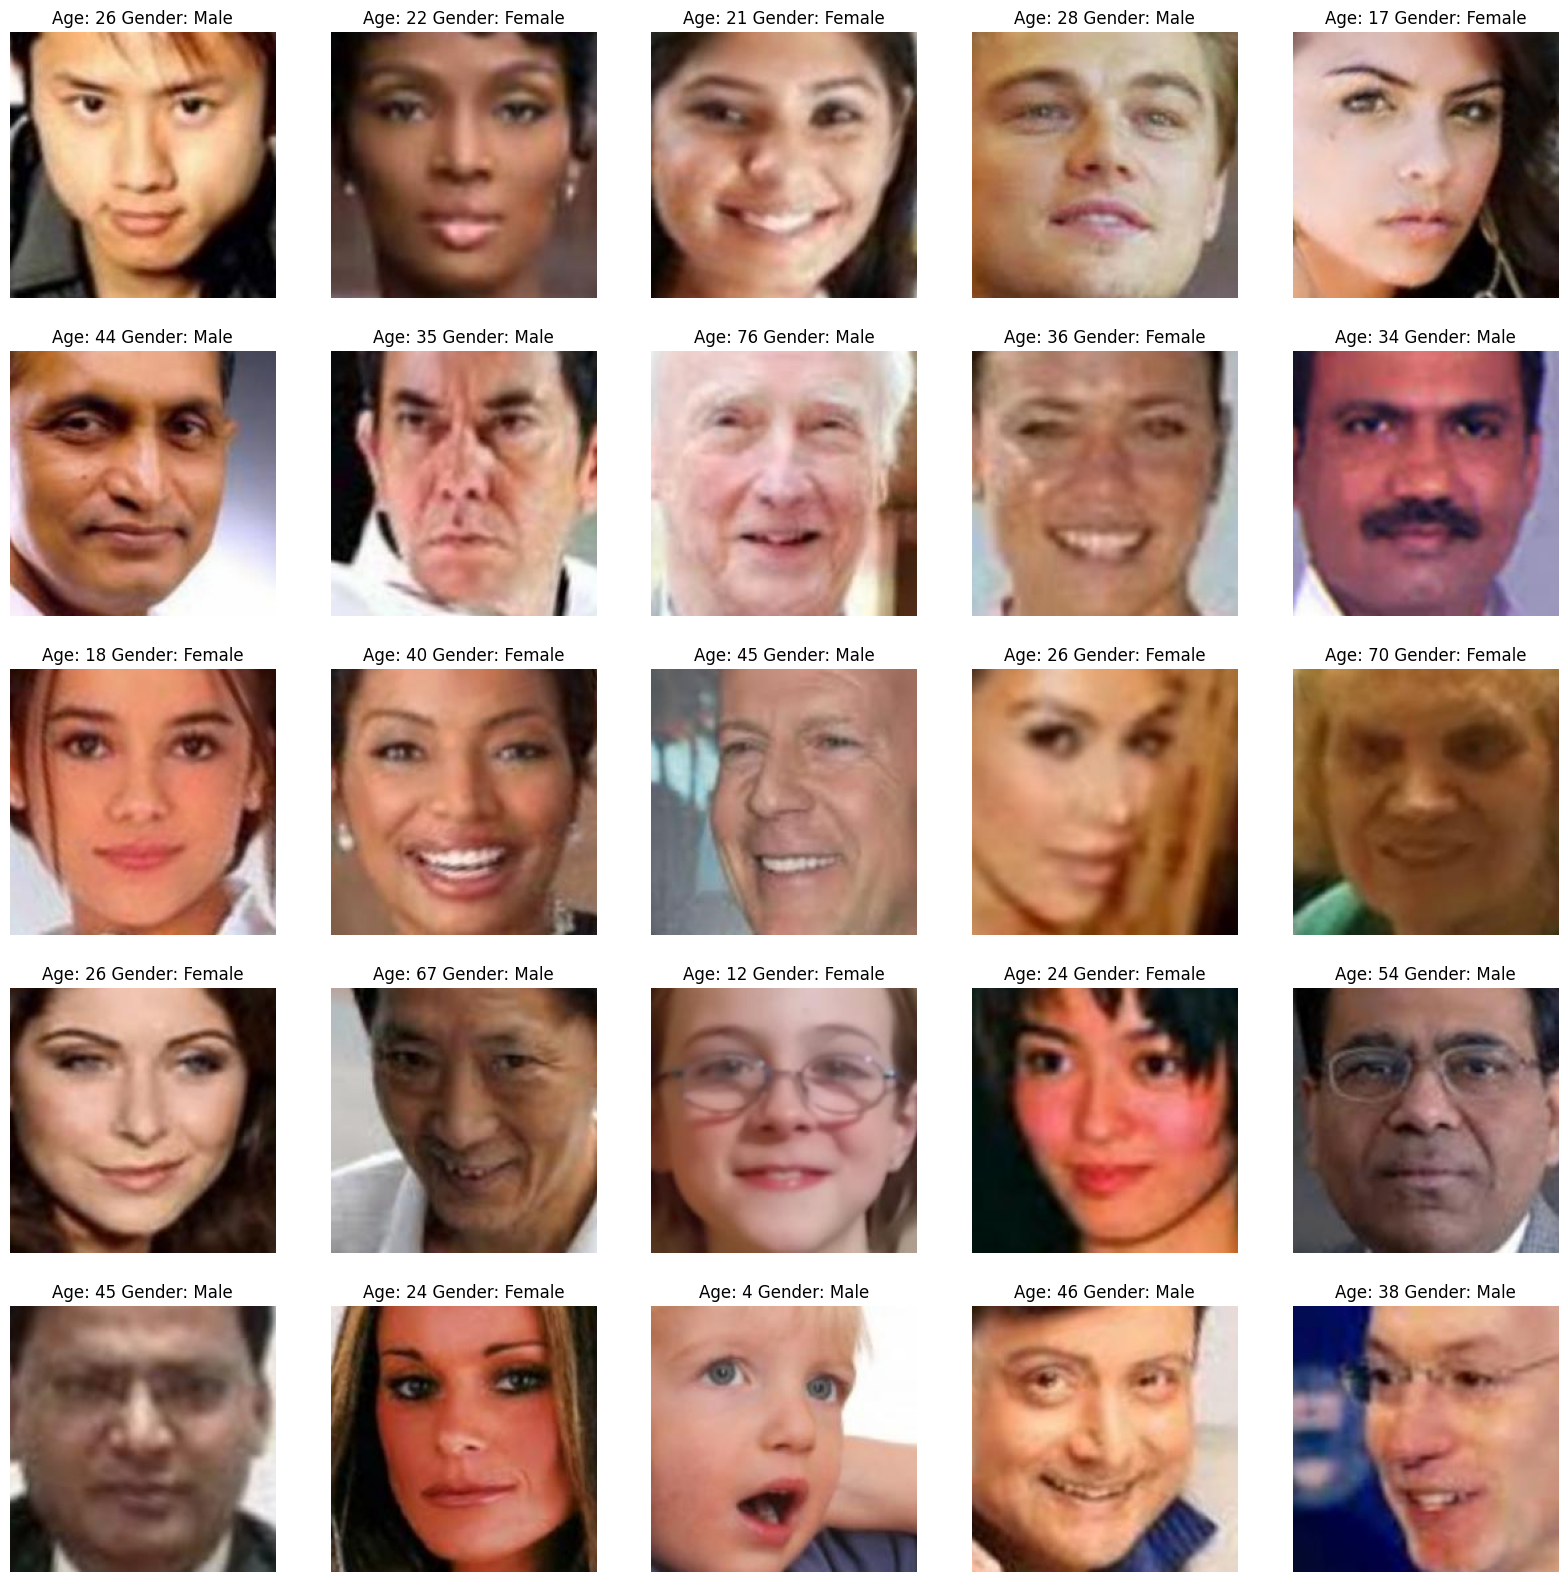

In [10]:
# to display grid of images
plt.figure(figsize=(20, 20))
files = df.iloc[0:25]

for index, file, age, gender in files.itertuples():
    plt.subplot(5, 5, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(f"Age: {age} Gender: {gender_dict[gender]}")
    plt.axis('off')

## Feature Extraction

In [11]:
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, color_mode='grayscale')
        img = img.resize((128, 128), Image.ANTIALIAS)
        img = np.array(img)
        features.append(img)
        
    features = np.array(features)
    # ignore this step if using RGB
    features = features.reshape(len(features), 128, 128, 1)
    return features

In [12]:
X = extract_features(df['image'])

  0%|          | 0/23708 [00:00<?, ?it/s]

In [13]:
X.shape

(23708, 128, 128, 1)

In [14]:
# normalize the images
X = X/255.0

In [15]:
y_gender = np.array(df['gender'])
y_age = np.array(df['age'])

In [16]:
input_shape = (128, 128, 1)

## Model Creation

In [18]:
inputs = Input((input_shape))
# convolutional layers
conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu') (inputs)
maxp_1 = MaxPooling2D(pool_size=(2, 2)) (conv_1)
conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu') (maxp_1)
maxp_2 = MaxPooling2D(pool_size=(2, 2)) (conv_2)
conv_3 = Conv2D(128, kernel_size=(3, 3), activation='relu') (maxp_2)
maxp_3 = MaxPooling2D(pool_size=(2, 2)) (conv_3)
conv_4 = Conv2D(256, kernel_size=(3, 3), activation='relu') (maxp_3)
maxp_4 = MaxPooling2D(pool_size=(2, 2)) (conv_4)

flatten = Flatten() (maxp_4)

# fully connected layers
dense_1 = Dense(256, activation='relu') (flatten)
dense_2 = Dense(256, activation='relu') (flatten)

dropout_1 = Dropout(0.4) (dense_1)
dropout_2 = Dropout(0.4) (dense_2)

output_1 = Dense(1, activation='sigmoid', name='gender_out') (dropout_1)
output_2 = Dense(1, activation='relu', name='age_out') (dropout_2)

model = Model(inputs=[inputs], outputs=[output_1, output_2])

model.compile(loss=['binary_crossentropy', 'mae'], optimizer='adam', metrics=['accuracy', 'mae'])

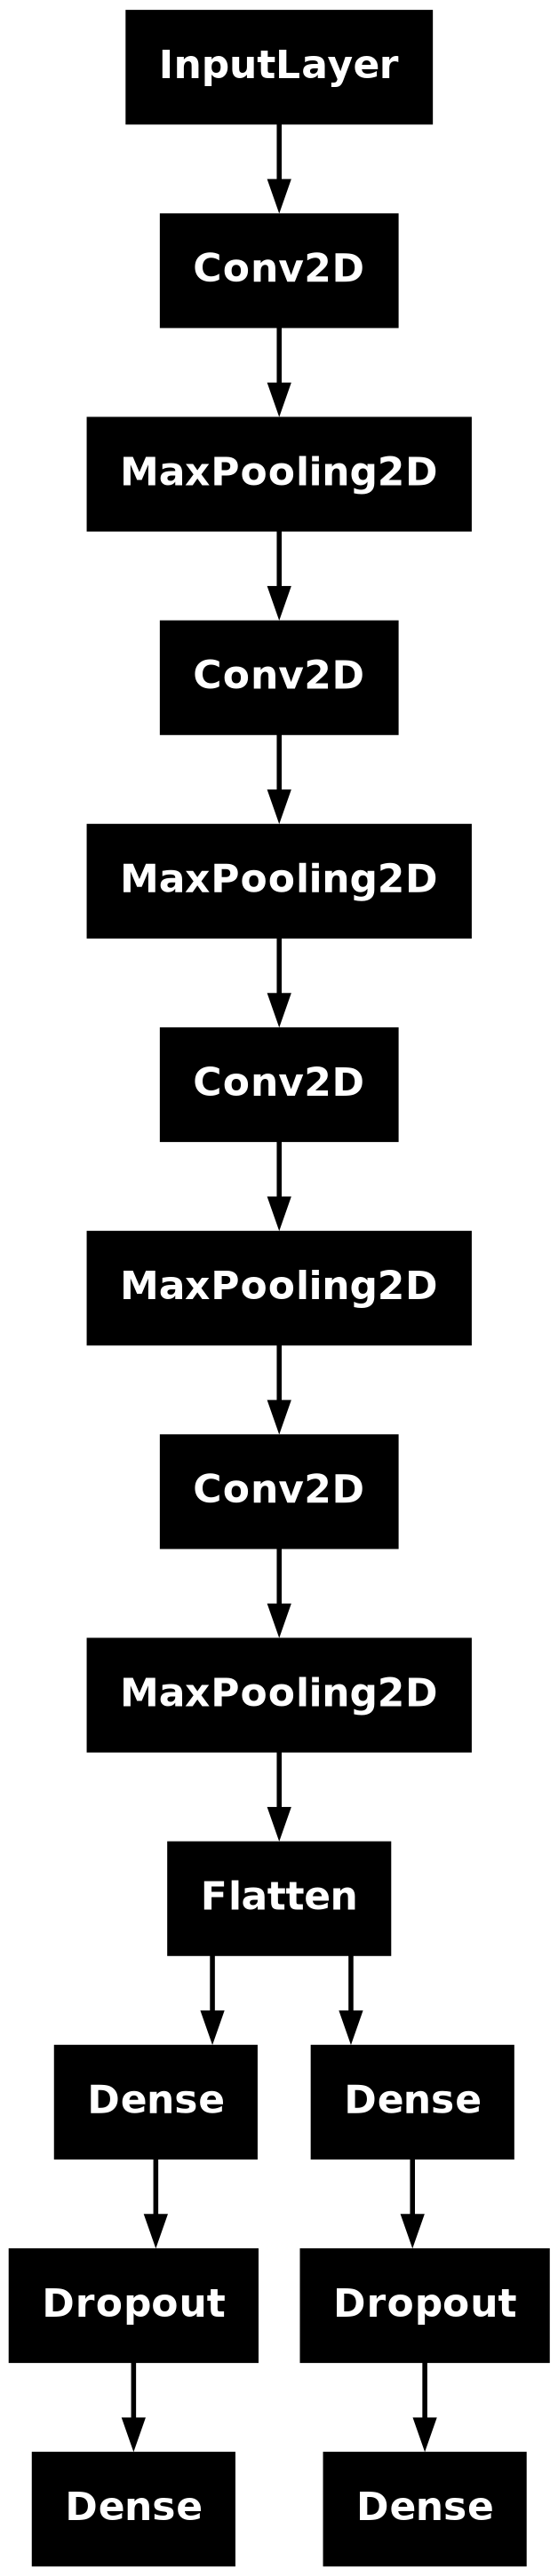

In [19]:
# plot the model
from tensorflow.keras.utils import plot_model
plot_model(model)

In [20]:
# train model
history = model.fit(x=X, y=[y_gender, y_age], batch_size=32, epochs=30, validation_split=0.2)

Epoch 1/30


2024-04-02 12:25:40.436231: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 3.39151, expected 2.7295
2024-04-02 12:25:40.436288: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 3.36773, expected 2.70572
2024-04-02 12:25:40.436298: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 3.08268, expected 2.42067
2024-04-02 12:25:40.436306: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 3.1679, expected 2.50589
2024-04-02 12:25:40.436314: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 2.96544, expected 2.30343
2024-04-02 12:25:40.436323: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 2.78427, expected 2.12226
2024-04-02 12:25:40.436331: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 2.73395, expected 2.07194
2024-04-02 12:25:40.436339: E external/local_xla/xla/serv

 16/593 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - age_out_mae: 24.4011 - gender_out_accuracy: 0.5641 - loss: 25.1875

I0000 00:00:1712060745.683957      85 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


591/593 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - age_out_mae: 16.3574 - gender_out_accuracy: 0.5304 - loss: 17.0569

2024-04-02 12:25:53.343217: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 15876: 3.41403, expected 2.91679
2024-04-02 12:25:53.343282: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 15879: 3.22873, expected 2.7315
2024-04-02 12:25:53.343297: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 15880: 3.40662, expected 2.90939
2024-04-02 12:25:53.343311: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 15881: 3.57666, expected 3.07943
2024-04-02 12:25:53.343327: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 15882: 2.6436, expected 2.14637
2024-04-02 12:25:53.343344: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 15883: 2.68105, expected 2.18382
2024-04-02 12:25:53.343355: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 15884: 2.65186, expected 2.15463
2024-04-02 12:25:53.343367: E

593/593 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - age_out_mae: 16.3516 - gender_out_accuracy: 0.5306 - loss: 17.0509

2024-04-02 12:26:00.592985: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 31752: 2.5113, expected 1.88489
2024-04-02 12:26:00.593051: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 31753: 2.58354, expected 1.95712
2024-04-02 12:26:00.593061: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 31754: 2.90737, expected 2.28095
2024-04-02 12:26:00.593069: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 31755: 2.50974, expected 1.88333
2024-04-02 12:26:00.593076: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 31756: 2.3616, expected 1.73519
2024-04-02 12:26:00.593084: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 31757: 2.47808, expected 1.85167
2024-04-02 12:26:00.593092: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 31758: 2.1855, expected 1.55908
2024-04-02 12:26:00.593100: E 

593/593 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - age_out_mae: 16.3487 - gender_out_accuracy: 0.5307 - loss: 17.0479 - val_age_out_mae: 11.3954 - val_gender_out_accuracy: 0.7512 - val_loss: 11.9640
Epoch 2/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - age_out_mae: 11.2721 - gender_out_accuracy: 0.7587 - loss: 11.7710 - val_age_out_mae: 11.5053 - val_gender_out_accuracy: 0.7680 - val_loss: 12.1079
Epoch 3/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - age_out_mae: 10.9708 - gender_out_accuracy: 0.7767 - loss: 11.4363 - val_age_out_mae: 10.0139 - val_gender_out_accuracy: 0.8199 - val_loss: 10.5350
Epoch 4/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - age_out_mae: 9.3148 - gender_out_accuracy: 0.8141 - loss: 9.7220 - val_age_out_mae: 9.5483 - val_gender_out_accuracy: 0.8229 - val_loss: 9.9408
Epoch 5/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - age_out_mae: 8.3898 - gender_out_accuracy: 0.8357 - loss: 8.7601 - val_age_out_mae: 7.8014 - val_gender_out_accuracy: 0.8433 - val_loss: 8.3495
Epo

## Plot the Results

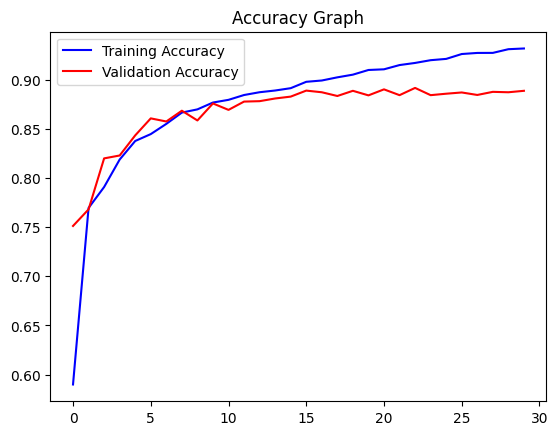

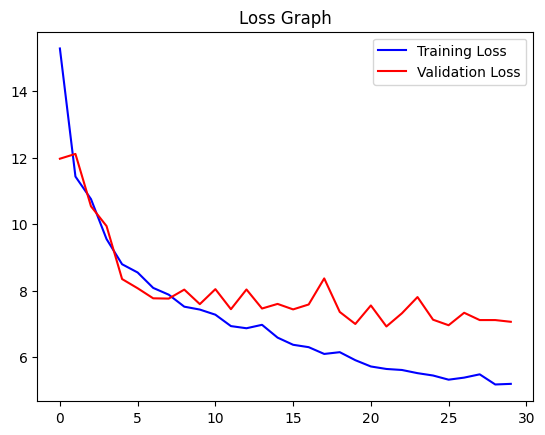

In [21]:
# plot results for gender
acc = history.history['gender_out_accuracy']
val_acc = history.history['val_gender_out_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

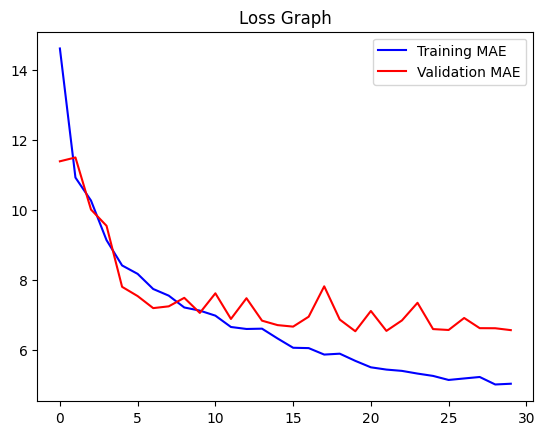

In [22]:
# plot results for age
loss = history.history['age_out_mae']
val_loss = history.history['val_age_out_mae']
epochs = range(len(loss))

plt.plot(epochs, loss, 'b', label='Training MAE')
plt.plot(epochs, val_loss, 'r', label='Validation MAE')
plt.title('Loss Graph')
plt.legend()
plt.show()

# Prediction with Test Data

Original Gender: Female Original Age: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Predicted Gender: Female Predicted Age: 3


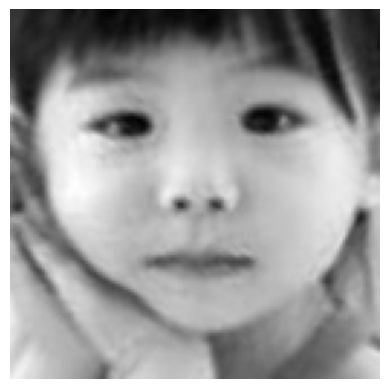

In [26]:
image_index = 100
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');

Original Gender: Male Original Age: 28
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Predicted Gender: Male Predicted Age: 33


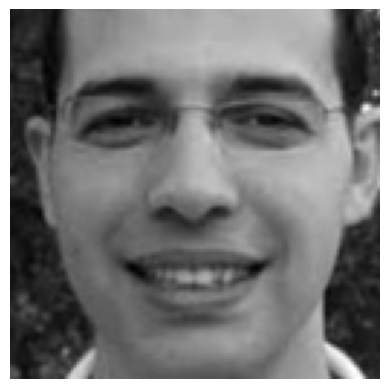

In [24]:
image_index = 3000
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');

Original Gender: Male Original Age: 42
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Predicted Gender: Male Predicted Age: 37


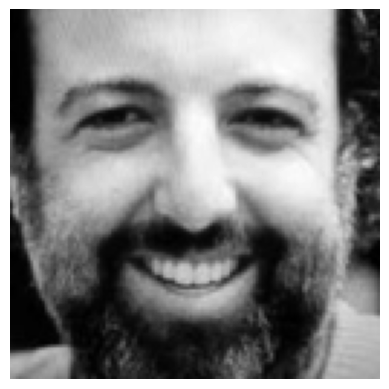

In [25]:
image_index = 10000
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');